# Decision Tree Regressor: Complete Mathematical Walkthrough
This notebook explains every step of the Decision Tree Regressor algorithm with mathematics and visualizations

# Decision Tree Regressors

A **Decision Tree Regressor** is a supervised learning algorithm that predicts continuous values by 
recursively partitioning the feature space into regions and predicting the mean value of training 
samples in each region.

## Key Concepts:
- **Recursive Binary Splitting**: The feature space is split recursively into smaller regions
- **Greedy Algorithm**: At each step, the best split is chosen without looking ahead
- **Prediction**: The mean of training samples in a leaf node becomes the prediction

# Mathematical Foundation

## MSE vs MAE: Choosing the Right Error Metric

Decision trees can use different metrics to measure prediction error and determine splits.
The two most common are **Mean Squared Error (MSE)** and **Mean Absolute Error (MAE)**.

### Mean Squared Error (MSE)
$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$

### Mean Absolute Error (MAE)
$
\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|
$

where $y_i$ is the actual value, $\hat{y}_i$ is the predicted value, and $n$ is the number of samples.

## Key Differences

1. **Treatment of Errors**: MSE squares errors (amplifying large ones), MAE takes absolute values (linear penalty)
2. **Outlier Sensitivity**: MSE is very sensitive to outliers, MAE is robust
3. **Units**: MSE is in squared units, MAE is in original units (more interpretable)
4. **Optimization**: MSE is smooth and easier to optimize, MAE has a kink at zero

**MSE-based tree:**
- Creates splits that try to minimize squared errors
- More influenced by outliers during training
- May create splits specifically to "handle" outlier points
- Better when large errors are particularly costly

**MAE-based tree:**
- Creates splits that minimize absolute errors
- More robust to outliers - treats them like any other point
- Produces more stable splits in presence of noise
- Better when you want consistent performance across all samples

## When to use:
- MSE: When large errors are critical
- MAE: When robustness to outliers matters

## Summary Table

| Aspect | MSE | MAE |
|--------|-----|-----|
| **Penalty** | Quadratic (error²) | Linear (\|error\|) |
| **Outlier sensitivity** | High | Low |
| **Units** | Squared | Original |
| **Interpretability** | Less intuitive | More intuitive |
| **Gradient** | Increases with error | Constant |
| **Use case** | Large errors critical | Robustness matters |

In practice, MSE is the default and most commonly used criterion for decision tree regressors,
but MAE can be valuable when your data contains outliers or when you want more robust predictions.

## The Splitting Criterion

At each node, we want to find the best feature $j$ and threshold $t$ to split the data. 
The goal is to minimize the **Mean Squared Error (MSE)** after the split.

### MSE for a Node

For a node $m$ with $n_m$ samples, the MSE is:

$$
\text{MSE}_m = \frac{1}{n_m} \sum_{i \in D_m} (y_i - \bar{y}_m)^2
$$

where:
- $D_m$ is the set of training samples in node $m$
- $y_i$ is the actual target value for sample $i$
- $\bar{y}_m = \frac{1}{n_m} \sum_{i \in D_m} y_i$ is the mean target value in node $m$

### Cost Function for a Split

When we split node $m$ into left child $m_L$ and right child $m_R$ using feature $j$ 
and threshold $t$, the weighted MSE is:

$$
J(j, t) = \frac{n_{m_L}}{n_m} \text{MSE}_{m_L} + \frac{n_{m_R}}{n_m} \text{MSE}_{m_R}
$$

where:
- $n_{m_L}$ = number of samples in left child
- $n_{m_R}$ = number of samples in right child
- $n_m = n_{m_L} + n_{m_R}$

### Optimal Split

We search for the pair $(j, t)$ that minimizes $J(j, t)$:

$$
(j^*, t^*) = \arg\min_{j,t} J(j, t)
$$

This is done through **exhaustive search** over all features and all possible thresholds.

## Step-by-Step Example with Calculations

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

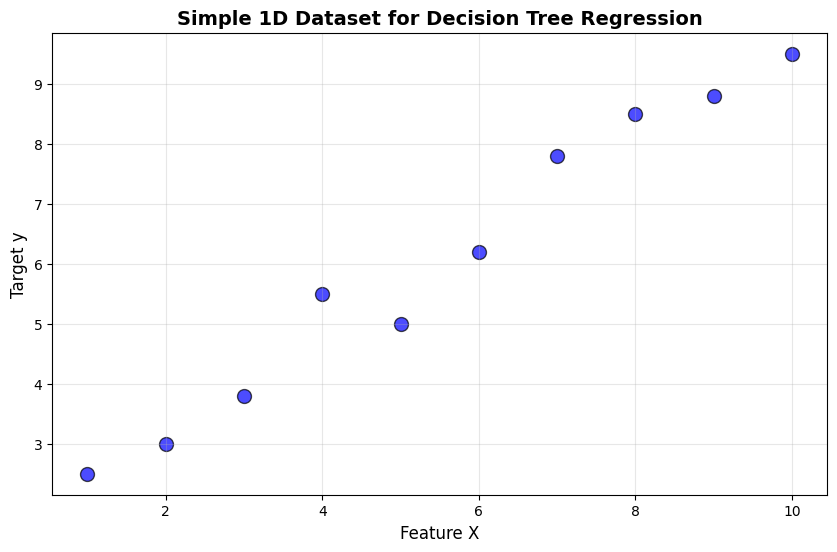

Dataset:
X: [ 1  2  3  4  5  6  7  8  9 10]
y: [2.5 3.  3.8 5.5 5.  6.2 7.8 8.5 8.8 9.5]


In [2]:
# Generate simple 1D dataset for clear visualization
X_simple = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]).reshape(-1, 1)
y_simple = np.array([2.5, 3.0, 3.8, 5.5, 5.0, 6.2, 7.8, 8.5, 8.8, 9.5])

plt.figure(figsize=(10, 6))
plt.scatter(X_simple, y_simple, c='blue', s=100, edgecolors='black', alpha=0.7)
plt.xlabel('Feature X', fontsize=12)
plt.ylabel('Target y', fontsize=12)
plt.title('Simple 1D Dataset for Decision Tree Regression', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.show()

print("Dataset:")
print(f"X: {X_simple.flatten()}")
print(f"y: {y_simple}")

# Step 1: Calculate Initial MSE (Root Node)

Before any splits, all data is at the root node. The prediction would be the mean of all y values.

$$
\bar{y}_{\text{root}} = \frac{1}{n} \sum_{i=1}^{n} y_i
$$

In [3]:
# Calculate root node statistics
y_mean_root = np.mean(y_simple)
mse_root = np.mean((y_simple - y_mean_root)**2)

print(f"\n{'='*60}")
print(f"ROOT NODE STATISTICS")
print(f"{'='*60}")
print(f"Number of samples (n): {len(y_simple)}")
print(f"Mean target value (ȳ): {y_mean_root:.3f}")
print(f"Root MSE: {mse_root:.3f}")
print(f"\nCalculation: MSE = (1/n) × Σ(yi - ȳ)²")
print(f"MSE = (1/{len(y_simple)}) × {np.sum((y_simple - y_mean_root)**2):.3f}")
print(f"MSE = {mse_root:.3f}")


ROOT NODE STATISTICS
Number of samples (n): 10
Mean target value (ȳ): 6.060
Root MSE: 5.692

Calculation: MSE = (1/n) × Σ(yi - ȳ)²
MSE = (1/10) × 56.924
MSE = 5.692


# Step 2: Finding the Best Split

We try all possible split points and calculate the weighted MSE for each.

For each potential threshold $t$ between consecutive x values:
1. Split data into left ($x \leq t$) and right ($x > t$) groups
2. Calculate MSE for each group
3. Calculate weighted average MSE
4. Choose split with minimum weighted MSE

In [4]:
# Method to calculate MSE for a given split threshold
def calculate_split_mse(X, y, threshold):
    left_mask = X.flatten() <= threshold
    right_mask = ~left_mask
    
    if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
        return float('inf'), None, None, None, None
    
    # Left child statistics
    y_left = y[left_mask]
    y_left_mean = np.mean(y_left)
    mse_left = np.mean((y_left - y_left_mean)**2)
    
    # Right child statistics
    y_right = y[right_mask]
    y_right_mean = np.mean(y_right)
    mse_right = np.mean((y_right - y_right_mean)**2)
    
    # Weighted MSE
    n_left = len(y_left)
    n_right = len(y_right)
    n_total = n_left + n_right
    
    weighted_mse = (n_left/n_total) * mse_left + (n_right/n_total) * mse_right
    
    return weighted_mse, mse_left, mse_right, n_left, n_right

In [5]:
# Try all possible splits (between consecutive points)
possible_thresholds = [(X_simple[i] + X_simple[i+1])[0]/2 for i in range(len(X_simple)-1)]

print(f"\n{'='*60}")
print(f"EVALUATING ALL POSSIBLE SPLITS")
print(f"{'='*60}\n")

split_results = []
for threshold in possible_thresholds:
    w_mse, mse_l, mse_r, n_l, n_r = calculate_split_mse(X_simple, y_simple, threshold)
    split_results.append({
        'threshold': threshold,
        'weighted_mse': w_mse,
        'mse_left': mse_l,
        'mse_right': mse_r,
        'n_left': n_l,
        'n_right': n_r
    })
    
    print(f"Threshold: X ≤ {threshold:.2f}")
    print(f"  Left:  n={n_l}, MSE={mse_l:.3f}")
    print(f"  Right: n={n_r}, MSE={mse_r:.3f}")
    print(f"  Weighted MSE: {w_mse:.3f}")
    print()


EVALUATING ALL POSSIBLE SPLITS

Threshold: X ≤ 1.50
  Left:  n=1, MSE=0.000
  Right: n=9, MSE=4.760
  Weighted MSE: 4.284

Threshold: X ≤ 2.50
  Left:  n=2, MSE=0.062
  Right: n=8, MSE=3.676
  Weighted MSE: 2.953

Threshold: X ≤ 3.50
  Left:  n=3, MSE=0.287
  Right: n=7, MSE=2.645
  Weighted MSE: 1.937

Threshold: X ≤ 4.50
  Left:  n=4, MSE=1.295
  Right: n=6, MSE=2.436
  Weighted MSE: 1.979

Threshold: X ≤ 5.50
  Left:  n=5, MSE=1.306
  Right: n=5, MSE=1.258
  Weighted MSE: 1.282

Threshold: X ≤ 6.50
  Left:  n=6, MSE=1.786
  Right: n=4, MSE=0.373
  Weighted MSE: 1.220

Threshold: X ≤ 7.50
  Left:  n=7, MSE=3.002
  Right: n=3, MSE=0.176
  Weighted MSE: 2.154

Threshold: X ≤ 8.50
  Left:  n=8, MSE=4.101
  Right: n=2, MSE=0.122
  Weighted MSE: 3.305

Threshold: X ≤ 9.50
  Left:  n=9, MSE=4.864
  Right: n=1, MSE=0.000
  Weighted MSE: 4.378



In [6]:
# Find best split
best_split = min(split_results, key=lambda x: x['weighted_mse'])
print(f"{'='*60}")
print(f"BEST SPLIT FOUND")
print(f"{'='*60}")
print(f"Threshold: X ≤ {best_split['threshold']:.2f}")
print(f"Weighted MSE: {best_split['weighted_mse']:.3f}")
print(f"MSE Reduction: {mse_root - best_split['weighted_mse']:.3f}")

BEST SPLIT FOUND
Threshold: X ≤ 6.50
Weighted MSE: 1.220
MSE Reduction: 4.472


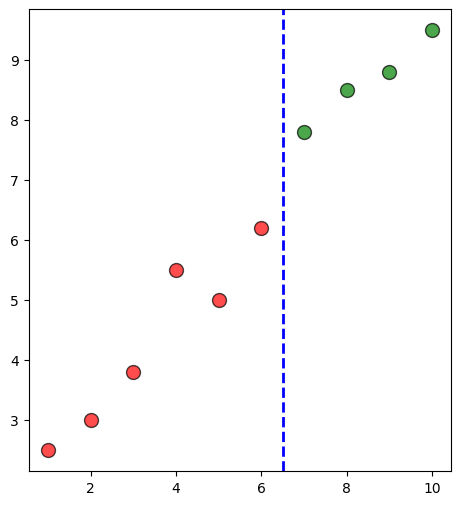

In [10]:
# Visualize the best split
plt.figure(figsize=(12, 6))
# Left panel: Show the split
plt.subplot(1, 2, 1)
left_mask = X_simple.flatten() <= best_split['threshold']
right_mask = ~left_mask

plt.scatter(X_simple[left_mask], y_simple[left_mask], c='red', s=100, 
            edgecolors='black', alpha=0.7, label=f'Left (X ≤ {best_split["threshold"]:.2f})')
plt.scatter(X_simple[right_mask], y_simple[right_mask], c='green', s=100, 
            edgecolors='black', alpha=0.7, label=f'Right (X > {best_split["threshold"]:.2f})')
plt.axvline(best_split['threshold'], color='blue', linestyle='--', linewidth=2, label='Split threshold')

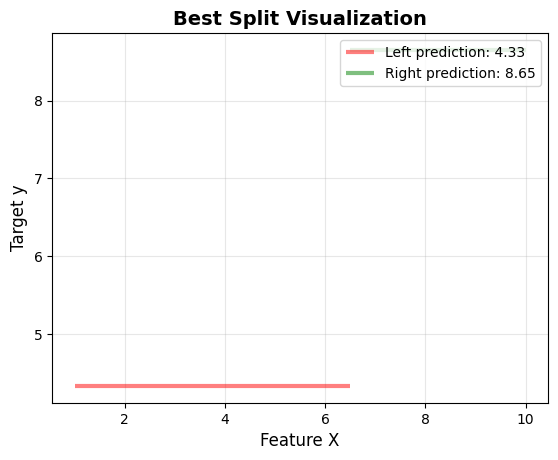

In [11]:
# Show predictions
y_left_mean = np.mean(y_simple[left_mask])
y_right_mean = np.mean(y_simple[right_mask])
plt.hlines(y_left_mean, X_simple[left_mask].min(), best_split['threshold'], 
           colors='red', linewidth=3, alpha=0.5, label=f'Left prediction: {y_left_mean:.2f}')
plt.hlines(y_right_mean, best_split['threshold'], X_simple[right_mask].max(), 
           colors='green', linewidth=3, alpha=0.5, label=f'Right prediction: {y_right_mean:.2f}')

plt.xlabel('Feature X', fontsize=12)
plt.ylabel('Target y', fontsize=12)
plt.title('Best Split Visualization', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

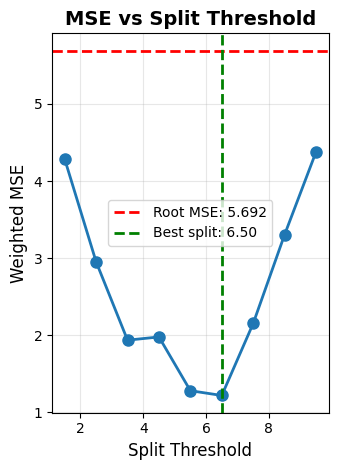

In [12]:
# Right panel: MSE comparison
plt.subplot(1, 2, 2)
thresholds = [s['threshold'] for s in split_results]
weighted_mses = [s['weighted_mse'] for s in split_results]

plt.plot(thresholds, weighted_mses, 'o-', linewidth=2, markersize=8)
plt.axhline(mse_root, color='red', linestyle='--', linewidth=2, label=f'Root MSE: {mse_root:.3f}')
plt.axvline(best_split['threshold'], color='green', linestyle='--', linewidth=2, 
            label=f'Best split: {best_split["threshold"]:.2f}')
plt.xlabel('Split Threshold', fontsize=12)
plt.ylabel('Weighted MSE', fontsize=12)
plt.title('MSE vs Split Threshold', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Step 3: Recursive Splitting

The algorithm continues recursively:
1. Apply the same process to each child node
2. Continue until stopping criteria are met:
   - Maximum depth reached
   - Minimum samples per node
   - No further MSE reduction possible

## Stopping Criteria

Common hyperparameters that control tree growth:

- **max_depth**: Maximum depth of the tree
- **min_samples_split**: Minimum samples required to split a node
- **min_samples_leaf**: Minimum samples required in a leaf node
- **min_impurity_decrease**: Minimum MSE reduction required for a split

## Complete Example with Real Dataset

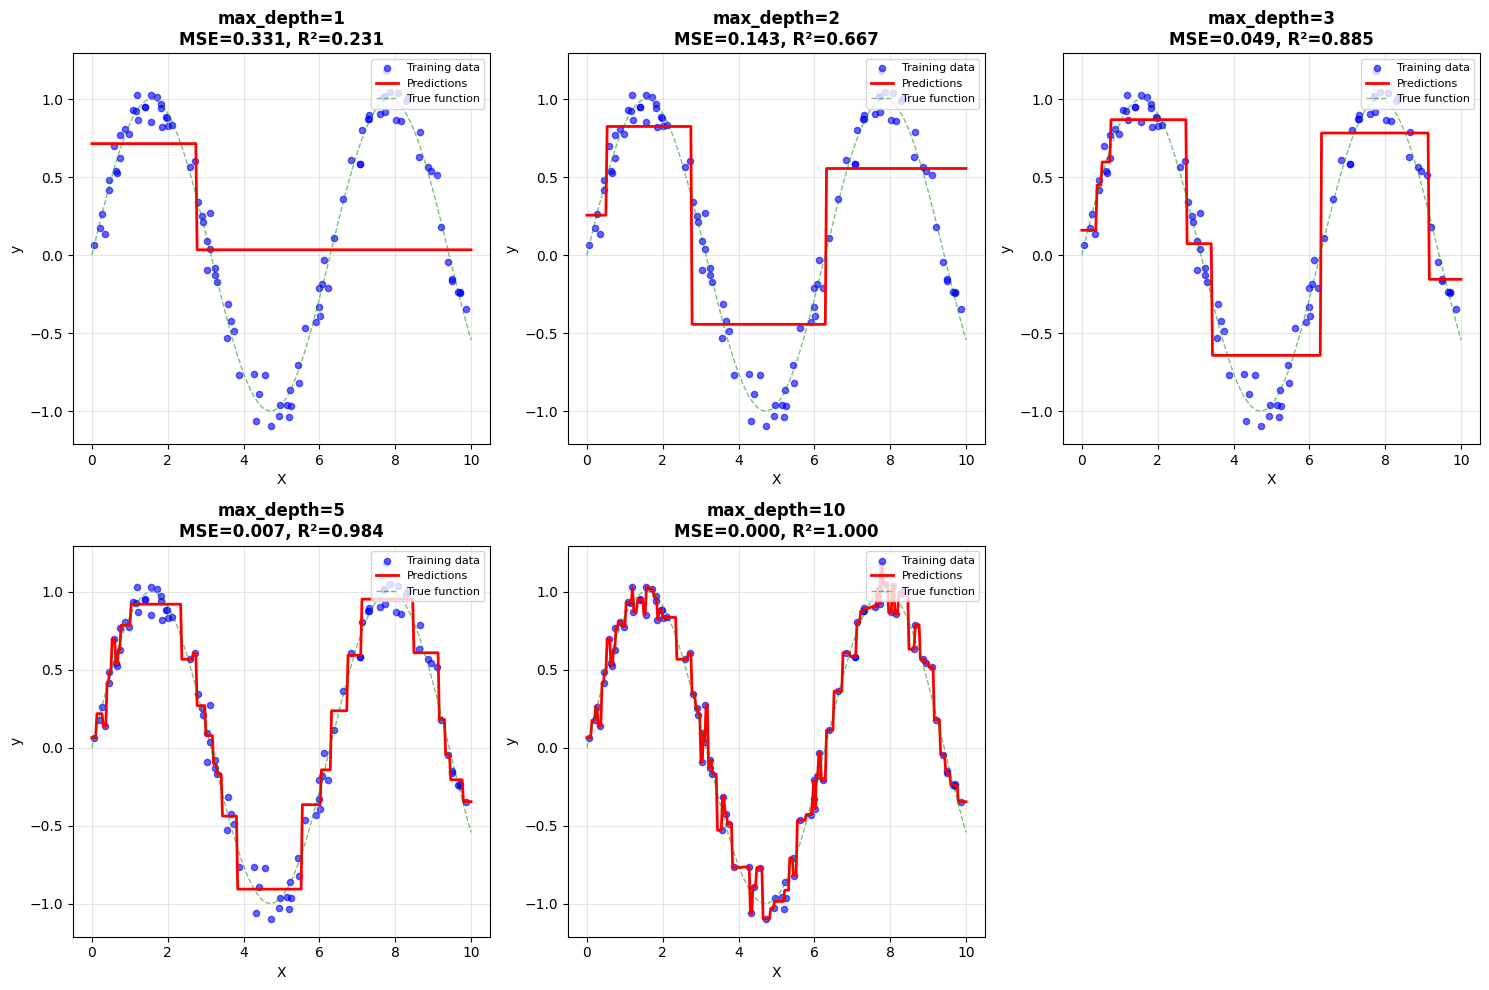

In [13]:
# Generate a more complex dataset
np.random.seed(42)
X_complex = np.sort(np.random.uniform(0, 10, 100)).reshape(-1, 1)
y_complex = np.sin(X_complex).ravel() + np.random.normal(0, 0.1, X_complex.shape[0])

# Train trees with different depths
depths = [1, 2, 3, 5, 10]
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, depth in enumerate(depths):
    # Train model
    tree = DecisionTreeRegressor(max_depth=depth, random_state=42)
    tree.fit(X_complex, y_complex)
    
    # Make predictions
    X_test = np.linspace(0, 10, 300).reshape(-1, 1)
    y_pred = tree.predict(X_test)
    
    # Calculate metrics
    y_train_pred = tree.predict(X_complex)
    train_mse = mean_squared_error(y_complex, y_train_pred)
    train_r2 = r2_score(y_complex, y_train_pred)
    
    # Plot
    axes[idx].scatter(X_complex, y_complex, c='blue', s=20, alpha=0.6, label='Training data')
    axes[idx].plot(X_test, y_pred, c='red', linewidth=2, label='Predictions')
    axes[idx].plot(X_test, np.sin(X_test), c='green', linewidth=1, 
                   linestyle='--', alpha=0.5, label='True function')
    axes[idx].set_title(f'max_depth={depth}\nMSE={train_mse:.3f}, R²={train_r2:.3f}', 
                        fontweight='bold')
    axes[idx].set_xlabel('X')
    axes[idx].set_ylabel('y')
    axes[idx].legend(loc='upper right', fontsize=8)
    axes[idx].grid(True, alpha=0.3)

# Remove extra subplot
fig.delaxes(axes[-1])
plt.tight_layout()
plt.show()

# Observations on Tree Depth

- **max_depth=1**: Very simple model (one split only) - underfitting
- **max_depth=2-3**: Captures general trend reasonably well
- **max_depth=5**: Good balance between bias and variance
- **max_depth=10**: Overfitting - memorizes training noise

As depth increases:
- Training error ↓ (better fit to training data)
- Model complexity ↑
- Risk of overfitting ↑

## Visualizing the Tree Structure

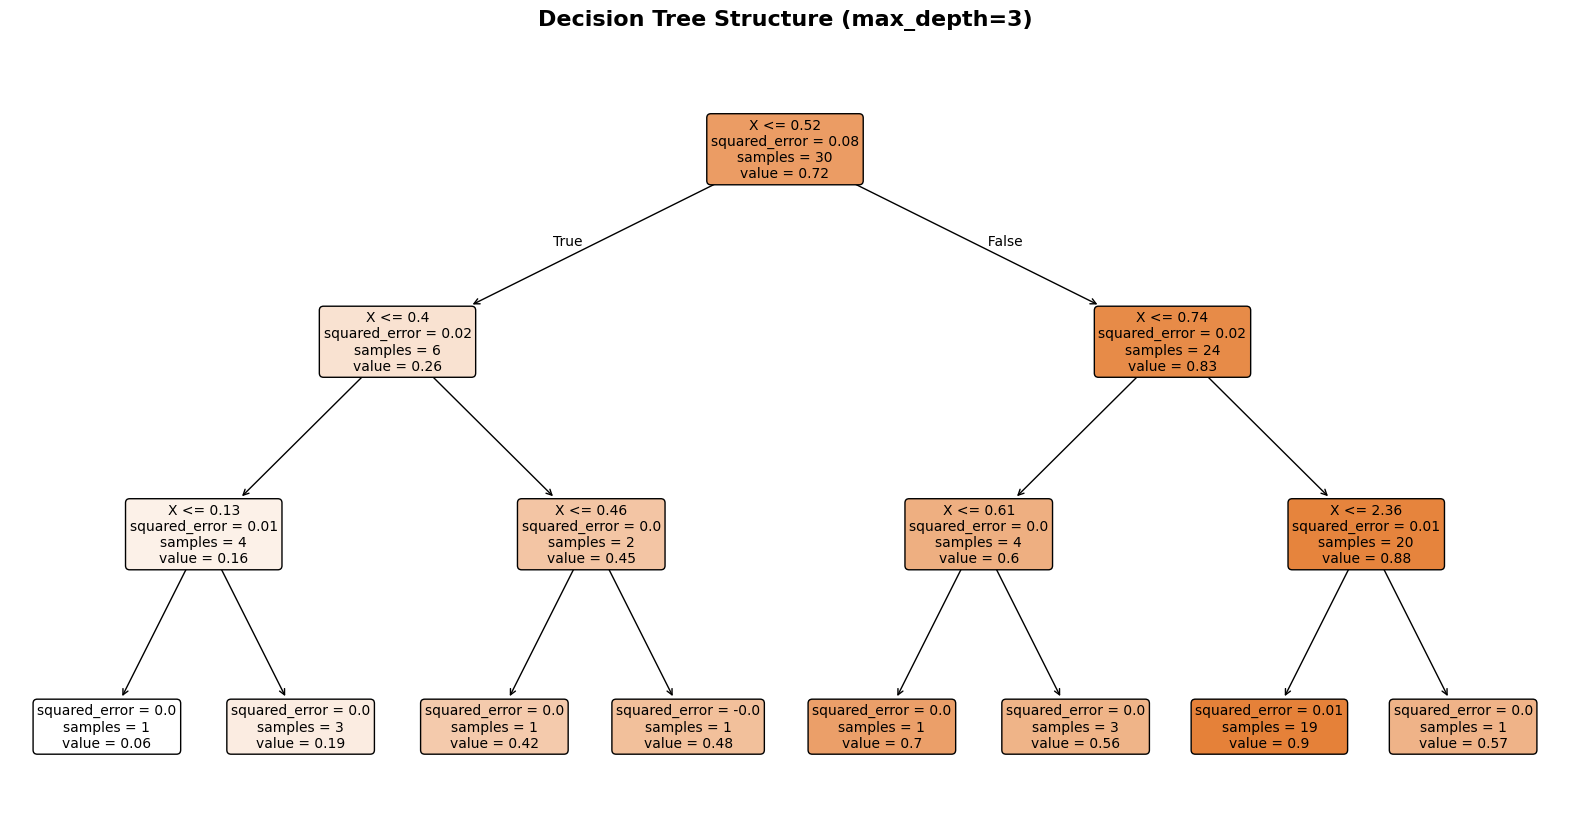

In [14]:
# Train a small tree for visualization
tree_viz = DecisionTreeRegressor(max_depth=3, random_state=42)
tree_viz.fit(X_complex[:30], y_complex[:30])  # Use subset for clarity

plt.figure(figsize=(20, 10))
plot_tree(tree_viz, filled=True, feature_names=['X'], 
          rounded=True, fontsize=10, precision=2)
plt.title('Decision Tree Structure (max_depth=3)', fontsize=16, fontweight='bold', pad=20)
plt.show()

# Understanding the Tree Visualization

Each node shows:
- **Split condition**: e.g., "X ≤ 5.23"
- **MSE**: Mean squared error at that node
- **samples**: Number of training samples in that node
- **value**: Predicted value (mean of samples in that node)

**Color intensity**: Darker colors indicate lower predicted values, lighter colors indicate higher values.

**Leaf nodes**: Terminal nodes (no further splits) - these make the final predictions.

# Feature Importance

Decision trees can calculate feature importance based on how much each feature 
reduces MSE across all splits.

$$
\text{Importance}(j) = \sum_{t \in \text{splits on } j} \frac{n_t}{n} \Delta \text{MSE}_t
$$

where:
- $n_t$ = number of samples at node $t$
- $n$ = total number of samples
- $\Delta \text{MSE}_t$ = MSE reduction from the split at node $t$

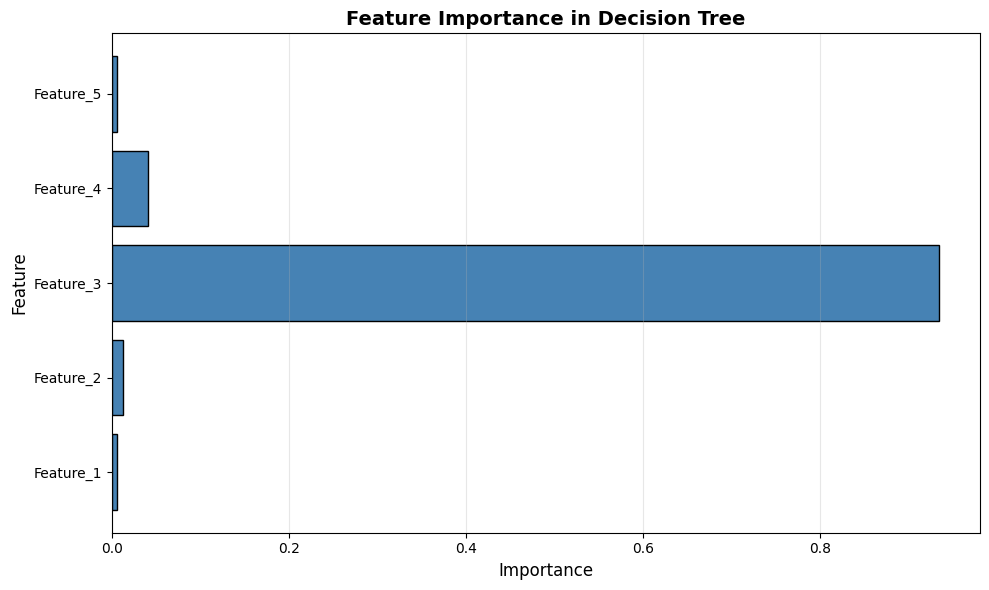


Feature Importances:
Feature_1: 0.0060
Feature_2: 0.0131
Feature_3: 0.9342
Feature_4: 0.0405
Feature_5: 0.0062


In [15]:
# Example with multiple features
from sklearn.datasets import make_regression

X_multi, y_multi = make_regression(n_samples=200, n_features=5, n_informative=3, 
                                    noise=10, random_state=42)
feature_names = ['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5']

# Train model
tree_multi = DecisionTreeRegressor(max_depth=5, random_state=42)
tree_multi.fit(X_multi, y_multi)

# Get feature importance
importances = tree_multi.feature_importances_

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances, color='steelblue', edgecolor='black')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Feature Importance in Decision Tree', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\nFeature Importances:")
for name, imp in zip(feature_names, importances):
    print(f"{name}: {imp:.4f}")

# Decision Tree Regressor vs Linear Regression

Let's compare how each model handles different types of relationships.

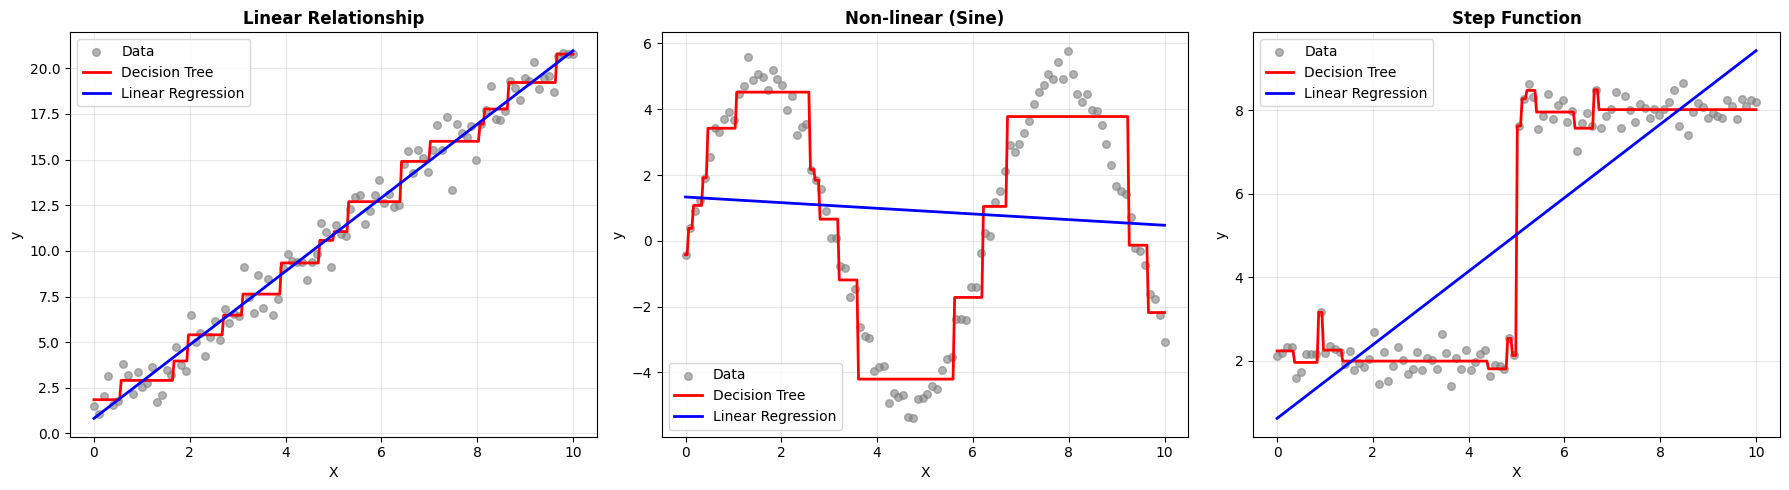

In [16]:
# Generate datasets with different patterns
np.random.seed(42)
n_samples = 100

# Dataset 1: Linear relationship
X_linear = np.linspace(0, 10, n_samples).reshape(-1, 1)
y_linear = 2 * X_linear.ravel() + 1 + np.random.normal(0, 1, n_samples)

# Dataset 2: Non-linear relationship
X_nonlinear = np.linspace(0, 10, n_samples).reshape(-1, 1)
y_nonlinear = np.sin(X_nonlinear.ravel()) * 5 + np.random.normal(0, 0.3, n_samples)

# Dataset 3: Step function
X_step = np.linspace(0, 10, n_samples).reshape(-1, 1)
y_step = np.where(X_step.ravel() < 5, 2, 8) + np.random.normal(0, 0.3, n_samples)

datasets = [
    (X_linear, y_linear, "Linear Relationship"),
    (X_nonlinear, y_nonlinear, "Non-linear (Sine)"),
    (X_step, y_step, "Step Function")
]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (X, y, title) in enumerate(datasets):
    # Train models
    from sklearn.linear_model import LinearRegression
    
    tree = DecisionTreeRegressor(max_depth=4, random_state=42)
    tree.fit(X, y)
    
    linear = LinearRegression()
    linear.fit(X, y)
    
    # Predictions
    X_test = np.linspace(0, 10, 300).reshape(-1, 1)
    y_tree = tree.predict(X_test)
    y_linear = linear.predict(X_test)
    
    # Plot
    axes[idx].scatter(X, y, c='gray', s=30, alpha=0.6, label='Data')
    axes[idx].plot(X_test, y_tree, c='red', linewidth=2, label='Decision Tree')
    axes[idx].plot(X_test, y_linear, c='blue', linewidth=2, label='Linear Regression')
    axes[idx].set_title(title, fontweight='bold', fontsize=12)
    axes[idx].set_xlabel('X')
    axes[idx].set_ylabel('y')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Key Takeaways

1. **Linear relationships**: Linear regression performs well and is more efficient
2. **Non-linear relationships**: Decision trees naturally capture complexity
3. **Discontinuous patterns**: Decision trees excel at step functions and thresholds

## Mathematical Summary

**Training Process:**
$$
\text{At each node: } (j^*, t^*) = \arg\min_{j,t} \left[ \frac{n_L}{n} \text{MSE}_L + \frac{n_R}{n} \text{MSE}_R \right]
$$

**Prediction:**
$$
\hat{y}(\mathbf{x}) = \bar{y}_{m^*}
$$
where $m^*$ is the leaf node that $\mathbf{x}$ falls into.

**Time Complexity:**
- Training: $O(n \cdot m \cdot \log n)$ where $n$ = samples, $m$ = features
- Prediction: $O(\log n)$ in average case (tree depth)

**Space Complexity:**
- $O(n)$ for storing the tree structure

# End of Tutorial